Files already downloaded and verified


C:\Users\flare\AppData\Local\Temp\ipykernel_1072\2752893404.py:84: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_1072\2752893404.py:84: UserWarning: Glyph 30011 (\N{CJK UNIFIED IDEOGRAPH-753B}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_1072\2752893404.py:84: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_1072\2752893404.py:84: UserWarning: Glyph 65306 (\N{FULLWIDTH COLON}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_1072\2752893404.py:84: UserWarning: Glyph 25973 (\N{CJK UNIFIED IDEOGRAPH-6575}) missing from current font.
  plt.tight_layout()
C:\Users\flare\AppData\Local\Temp\ipykernel_1072\2752893404.py:84: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from current 

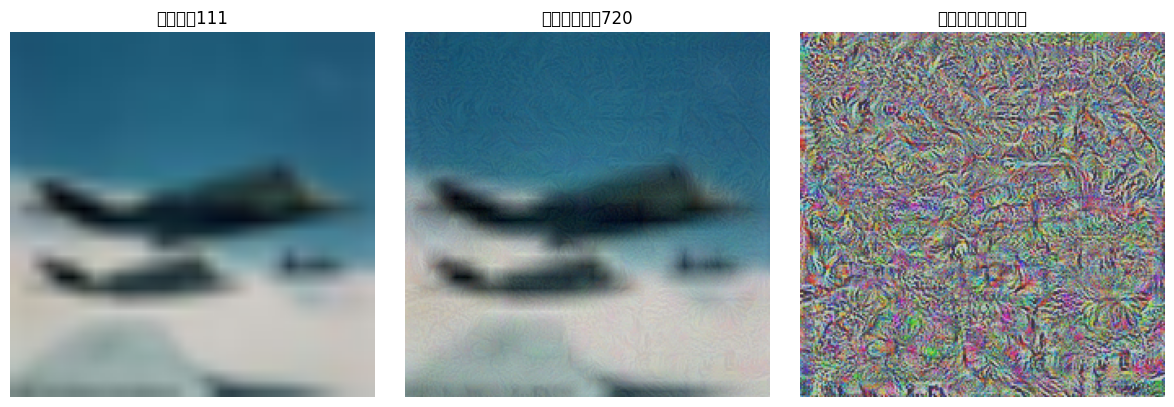

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18

# 日本語フォントの設定（Windows例：メイリオ）
matplotlib.rcParams['font.family'] = 'Meiryo'  # 他に 'IPAexGothic' などでも可


# --- 1. デバイス設定 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 2. CIFAR-10データセット準備（ResNet用に224x224へ変換） ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)

# --- 3. 事前学習済みResNet18モデルの読み込み（ImageNet用） ---
model = resnet18(pretrained=True).to(device)
model.eval()

# --- 4. PGD攻撃関数定義 ---
def pgd_attack(model, images, labels, eps=0.03, alpha=0.005, iters=10):
    images = images.clone().detach().to(device)
    ori_images = images.clone().detach()
    labels = labels.to(device)

    for _ in range(iters):
        images.requires_grad = True
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()
        grad = images.grad.data

        adv_images = images + alpha * grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach()

    return images

# --- 5. 可視化用関数 ---
def imshow(img_tensor, title=''):
    npimg = img_tensor.cpu().numpy()
    npimg = np.transpose(npimg, (1, 2, 0))  # CHW → HWC
    plt.imshow(np.clip(npimg, 0, 1))
    plt.title(title)
    plt.axis('off')

# --- 6. 1枚だけ取得して攻撃・可視化 ---
data_iter = iter(testloader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

# 元画像の予測
outputs_clean = model(images)
pred_clean = outputs_clean.argmax(dim=1)

# PGD攻撃
adv_images = pgd_attack(model, images, labels, eps=0.03, alpha=0.005, iters=10)
outputs_adv = model(adv_images)
pred_adv = outputs_adv.argmax(dim=1)

# 差分（ノイズ）画像
delta = adv_images - images

# --- 7. 結果表示 ---
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
imshow(images[0], f"元画像：{pred_clean.item()}")

plt.subplot(1, 3, 2)
imshow(adv_images[0], f"敵対的画像：{pred_adv.item()}")

plt.subplot(1, 3, 3)
imshow(delta[0] * 10 + 0.5, "ノイズ（強調表示）")

plt.tight_layout()
plt.show()
